In [24]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.stats import mode
from matplotlib import pyplot as plt


data = pd.read_json("../../../data.json")

data["iqs"] = data["iq"].map(lambda x: [x[i:i+6] for i in range(16,len(x),6)][:-1]) 
data.sample(2)

,index,mac,timestamp,no,rssi,raw,frequency,iq,angle,distance,capture,ref,a1,a2,a3,a2a1,a3a2,a3a1,iqs
618,165,c300000a7a48,2024-10-04 16:57:50.561000+00:00,0,-55,0201061bff3906cafb0114feffe9ff0201000000000000...,2426,"[23, -159, 145, 57, -84, 133, -111, -101, 114,...",0,200.0,tw,"[-1.4271387106, 0.3745469721, 2.1341125883, -2...","[-0.79124605, -3.0509327664, 1.1108251718, -1....","[-0.0145620774, -2.2142974356, 1.9568224271, -...","[1.6951513213, -0.5213263434000001, -2.6886684...","[0.7766839726, 0.8366353308000001, 0.845997255...","[1.7097133987, 1.6929710922, 1.637694386000000...","[2.4863973713, 2.529606423, 2.4836916412, 2.62...","[[85, -86, 206, -3, -21, 168], [-121, -11, -12..."
3740,51,c300000a7a48,2024-10-04 17:42:07.709000+00:00,0,-51,0201061bff3906cafb01140000ffe700fd000000000000...,2426,"[10, 178, -190, 6, 31, -146, 156, 87, -94, 151...",150,150.0,tw,"[1.5146755441000002, 3.1100241971, -1.36157477...","[0.8245937653000001, -1.2355330814, 2.80349478...","[0.6891447982000001, -1.5194396565, 2.52362626...","[-0.25518239060000003, -2.3791789476, 1.703347...","[-0.1354489672, -0.2839065751, -0.279868513000...","[-0.9443271888, -0.8597392911, -0.8202784096, ...","[-1.0797761559, -1.1436458662, -1.1001469226, ...","[[147, 159, 159, 131, 115, -30], [77, -221, 11..."


In [25]:
data["iq"].iloc[0][16:16+6] == data["iqs"].iloc[0][0]

True

# PD in each line

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

tsamples =[]
tlabels =[]

vsamples=[]
vlabels=[]

tdataset, vdataset = train_test_split(data[data["capture"]== "tw"],test_size=0.2)

for row in tdataset.iterrows():
    for element in row[1]["iqs"]:
        tsamples.append(element)
        tlabels.append(row[1]["angle"])

for row in vdataset.iterrows():
    for element in row[1]["iqs"]:
        vsamples.append(element)
        vlabels.append(row[1]["angle"])

X_train = tsamples
y_train = [label//15 for label in tlabels ]

X_test = vsamples
y_test = [label//15 for label in vlabels ]


array_names= ([str(name) for name in range(0,180+15,15)])

In [28]:

#Splitting the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Creating an XGBoost classifier
model = xgb.XGBClassifier(enable_categorical=True)

#Training the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#Making predictions on the test set
predictions = model.predict(X_test)

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=array_names))

Accuracy: 0.9657046377882129

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1595
          15       0.95      0.94      0.94      1529
          30       0.93      0.94      0.93      1375
          45       0.96      0.99      0.97      1144
          60       0.99      0.98      0.98      1463
          75       0.96      0.97      0.96      1122
          90       0.97      0.96      0.96      1342
         105       0.96      0.95      0.96      1672
         120       0.96      0.97      0.96      1496
         135       0.98      0.98      0.98      1584
         150       0.97      0.99      0.98      1496
         165       0.97      0.97      0.97      1562
         180       0.99      0.99      0.99      1573

    accuracy                           0.97     18953
   macro avg       0.97      0.97      0.97     18953
weighted avg       0.97      0.97      0.97     18953



In [31]:
results_labels= []
results_values = []
for row in vdataset.iterrows():
    pred=[]
    for element in row[1]["iqs"]:
        pred.append(model.predict([element])[0])
    results_labels.append((row[1]["angle"]//15))
    results_values.append(mode(pred)[0][0])

C:\Users\pedro\AppData\Local\Temp\ipykernel_24128\1891308053.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  results_values.append(mode(pred)[0][0])


In [32]:
#Calculating accuracy
accuracy = accuracy_score(results_labels, results_values)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(results_labels, results_values, target_names=array_names))

Accuracy: 0.9872315728380732

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       145
          15       0.99      0.98      0.99       139
          30       0.99      0.98      0.99       125
          45       0.99      1.00      1.00       104
          60       0.99      1.00      1.00       133
          75       0.98      1.00      0.99       102
          90       0.99      0.97      0.98       122
         105       0.97      0.97      0.97       152
         120       0.96      0.98      0.97       136
         135       0.99      0.99      0.99       144
         150       1.00      1.00      1.00       136
         165       0.99      0.99      0.99       142
         180       1.00      0.99      1.00       143

    accuracy                           0.99      1723
   macro avg       0.99      0.99      0.99      1723
weighted avg       0.99      0.99      0.99      1723



In [33]:
results = {str(l):[] for l in set(vlabels)}

for row in vdataset.iterrows():
    pred=[]
    for element in row[1]["iqs"]:
        pred.append(model.predict([element])[0])
    results[str(row[1]["angle"])].append(mode(pred)[0][0]*15)

C:\Users\pedro\AppData\Local\Temp\ipykernel_24128\1088276325.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  results[str(row[1]["angle"])].append(mode(pred)[0][0]*15)


In [34]:
for key, values in results.items():
    print(f"Angulo {key}\n" )
    for judgement in set(values):
        print(f"\t {judgement} = {100*values.count(judgement)/len(values)}% ")

Angulo 0

	 0 = 99.3103448275862% 
	 30 = 0.6896551724137931% 
Angulo 165

	 105 = 0.704225352112676% 
	 165 = 99.29577464788733% 
Angulo 135

	 120 = 1.3888888888888888% 
	 135 = 98.61111111111111% 
Angulo 105

	 120 = 2.6315789473684212% 
	 105 = 96.71052631578948% 
	 90 = 0.6578947368421053% 
Angulo 75

	 75 = 100.0% 
Angulo 45

	 45 = 100.0% 
Angulo 15

	 0 = 1.4388489208633093% 
	 45 = 0.7194244604316546% 
	 15 = 97.84172661870504% 
Angulo 180

	 180 = 99.3006993006993% 
	 165 = 0.6993006993006993% 
Angulo 150

	 150 = 100.0% 
Angulo 120

	 120 = 97.79411764705883% 
	 105 = 1.4705882352941178% 
	 135 = 0.7352941176470589% 
Angulo 90

	 105 = 0.819672131147541% 
	 90 = 96.72131147540983% 
	 75 = 1.639344262295082% 
	 60 = 0.819672131147541% 
Angulo 60

	 60 = 100.0% 
Angulo 30

	 0 = 0.8% 
	 30 = 98.4% 
	 15 = 0.8% 


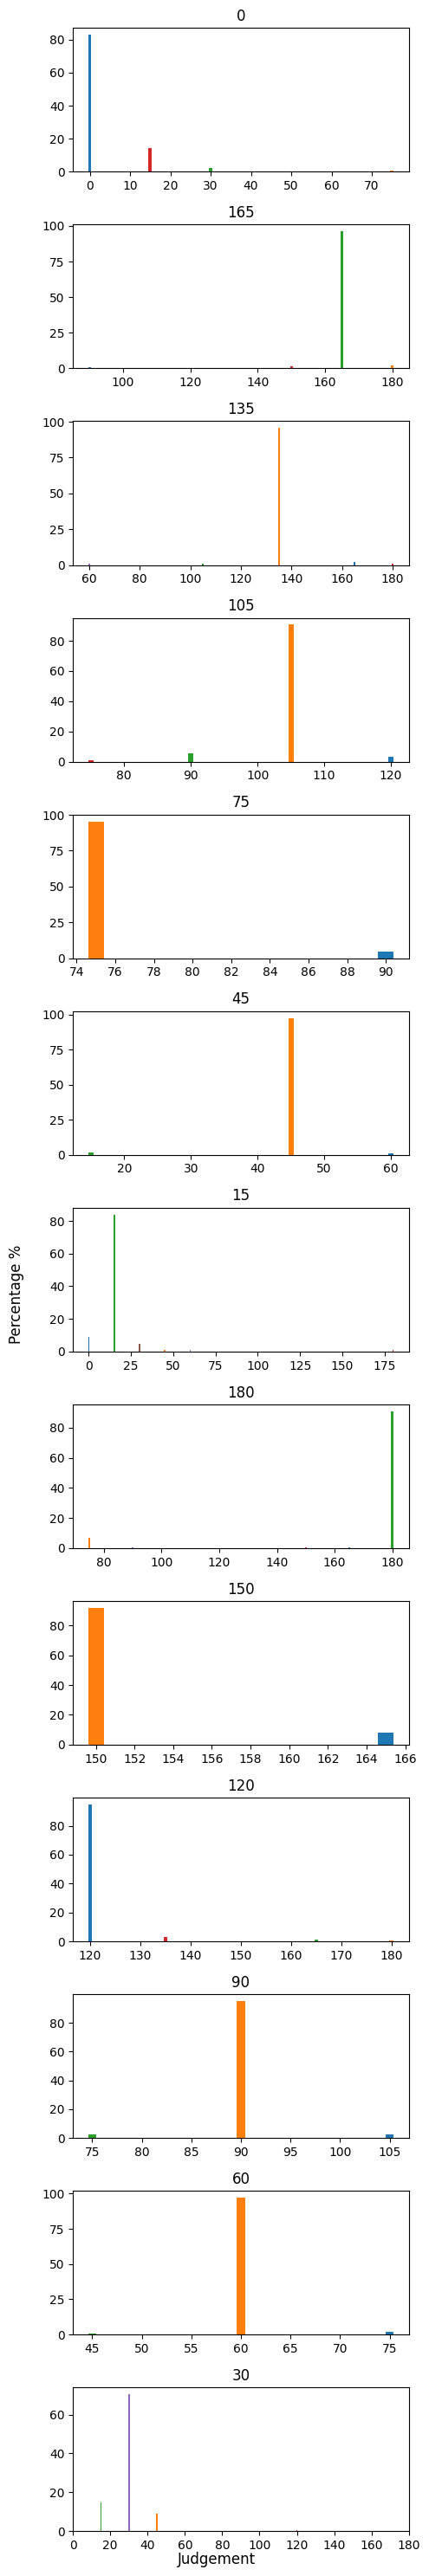

In [9]:
fig, ax = plt.subplots(len(set(results.keys())),figsize=(5,30))
fig.set_tight_layout(True)

fig.supylabel("Percentage %")
fig.supxlabel("Judgement")


for i, pair in enumerate(results.items()):
    for judgement in set(pair[1]):
        ax[i].title.set_text(pair[0])
        ax[i].bar(judgement,100*pair[1].count(judgement)/len(pair[1]),0.8)
        plt.xlim(0,180)


In [35]:
model.save_model("./xgb_classifier.json")